# Simon Fraser University
## CMPT 413 Final Project
## Prompt-based Text Matching Methods for Fake News Stance Detection

### Group AWSL: Zeyong Jin; Yuqing Wu; Zhi Feng.

In [ ]:
import warnings
warnings.filterwarnings('ignore')

## Load Fake News Challenge Data

Open source: https://github.com/FakeNewsChallenge/fnc-1.git

In [ ]:
! git clone https://github.com/FakeNewsChallenge/fnc-1.git

fatal: destination path 'fnc-1' already exists and is not an empty directory.


## Pre-pocessing

### Load csv files.

In [ ]:
# Prepare the data files needed for this project.

import os
import random
import pandas as pd
import numpy as np

fcn_dir = "fnc-1"

train_bodies_df = pd.read_csv(os.path.join(fcn_dir, "train_bodies.csv"), index_col=["Body ID"])
train_stances_df = pd.read_csv(os.path.join(fcn_dir, "train_stances.csv"), usecols=["Body ID", "Headline", "Stance"])

test_bodies_df = pd.read_csv(os.path.join(fcn_dir, "competition_test_bodies.csv"), index_col=["Body ID"])
test_stances_df = pd.read_csv(os.path.join(fcn_dir, "competition_test_stances.csv"), usecols=["Body ID", "Headline", "Stance"])


In [ ]:
test_stances_df = test_stances_df.reset_index()
test_stances_df.columns = ["UniqueID","Headline", "Body ID", "Stance"]
test_stances_df

,UniqueID,Headline,Body ID,Stance
0,0,Ferguson riots: Pregnant woman loses eye after...,2008,unrelated
1,1,Crazy Conservatives Are Sure a Gitmo Detainee ...,1550,unrelated
2,2,A Russian Guy Says His Justin Bieber Ringtone ...,2,unrelated
3,3,"Zombie Cat: Buried Kitty Believed Dead, Meows ...",1793,unrelated
4,4,Argentina's President Adopts Boy to End Werewo...,37,unrelated
...,...,...,...,...
25408,25408,The success of the Affordable Care Act is a hu...,2582,agree
25409,25409,The success of the Affordable Care Act is a hu...,2583,discuss
25410,25410,The success of the Affordable Care Act is a hu...,2584,disagree
25411,25411,The success of the Affordable Care Act is a hu...,2585,disagree


In [ ]:
test_bodies_df

,articleBody
Body ID,
1,Al-Sisi has denied Israeli reports stating tha...
2,A bereaved Afghan mother took revenge on the T...
3,CNBC is reporting Tesla has chosen Nevada as t...
12,A 4-inch version of the iPhone 6 is said to be...
19,GR editor’s Note\n\nThere are no reports in th...
...,...
2582,"Congressional Republicans, evidently hoping th..."
2583,Did Obamacare work?\n\nIt’s worth reflecting u...
2584,Millions may lose coverage next year if Congre...


### Convert & Merge

In [ ]:
def convert_stance_to_int(stance: str) -> int:
    mapping = {
        "unrelated": 0,
        "discuss"  : 1,
        "agree"    : 2,
        "disagree" : 3
    }
    return mapping[stance]

def convert_int_to_stance(stance_id: int) -> str:
    mapping = {
        0: "unrelated",
        1: "discuss",
        2: "agree",
        3: "disagree"
    }
    return mapping[stance_id]

n_classes = 4

In [ ]:
train_stances_df["Stance"] = train_stances_df["Stance"].apply(lambda x: convert_stance_to_int(x))
test_stances_df["Stance"] = test_stances_df["Stance"].apply(lambda x: convert_stance_to_int(x))


In [ ]:
train_df = pd.merge(left=train_stances_df, left_on=train_stances_df["Body ID"],
                    right=train_bodies_df, right_on=train_bodies_df.index)
train_df = train_df.sample(frac=1)
train_df["Mixed"] = train_df["Headline"] + "[SEP]" + train_df["articleBody"] 
train_df = train_df[["Body ID", "Mixed", "Stance"]]
train_df

,Body ID,Mixed,Stance
40261,752,Did Kim Yo-Jong Take Kim Jong Un’s Role? North...,0
33359,1166,ISIS beheads American photo-journalist James W...,0
27620,2272,Rumor: Seth Rogen to Appear as Woz in Sony's S...,0
41445,493,Purported ISIS claim: Jordan airstrike kills f...,0
14838,1605,"Catholic priest dies for 48 mins, wakes up cla...",0
...,...,...,...
41291,1427,Mexico hit by student massacre: At least 17 an...,3
14137,2403,New Audio Allegedly Captures Moment Michael Br...,0
5354,1744,"Apple Watch to Be Shower-Proof, Have 100,000 A...",0
15195,1489,11 jetliners 'missing' after Islamist takeover...,0


In [ ]:
test_df = pd.merge(left=test_stances_df, left_on=test_stances_df["Body ID"],
                    right=test_bodies_df, right_on=test_bodies_df.index, left_index=True)
test_df["Mixed"] = test_df["Headline"] + "[SEP]" + test_df["articleBody"] 
test_df = test_df[["UniqueID", "Body ID", "Mixed", "Stance"]]

test_df = test_df.sort_values(by="UniqueID")
test_df

,UniqueID,Body ID,Mixed,Stance
Body ID,,,,
2008,0,2008,Ferguson riots: Pregnant woman loses eye after...,0
1550,1,1550,Crazy Conservatives Are Sure a Gitmo Detainee ...,0
2,2,2,A Russian Guy Says His Justin Bieber Ringtone ...,0
1793,3,1793,"Zombie Cat: Buried Kitty Believed Dead, Meows ...",0
37,4,37,Argentina's President Adopts Boy to End Werewo...,0
...,...,...,...,...
2582,25408,2582,The success of the Affordable Care Act is a hu...,2
2583,25409,2583,The success of the Affordable Care Act is a hu...,1
2584,25410,2584,The success of the Affordable Care Act is a hu...,3


## Logistic Regression & Naive Bayes

### TFIDF and Count

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import label_binarize

train_count_vec = CountVectorizer(ngram_range=(1,2), stop_words="english")
train_tfidf_vec = TfidfVectorizer(ngram_range=(1,2), stop_words="english")

train_binarized_X = train_df["Mixed"]
train_binarized_y = label_binarize(train_df["Stance"], classes=[0, 1, 2, 3])
n_classes = train_binarized_y.shape[1]


In [ ]:
train_count_encoding = train_count_vec.fit_transform(train_binarized_X)
train_tfidf_encoding = train_tfidf_vec.fit_transform(train_binarized_X)

In [ ]:
test_binarized_X = test_df["Mixed"]
test_binarized_y = label_binarize(test_df["Stance"], classes=[0, 1, 2, 3])

test_count_encoding = train_count_vec.transform(test_binarized_X)
test_tfidf_encoding = train_tfidf_vec.transform(test_binarized_X)

### Visualize 


In [ ]:
from itertools import cycle

def roc_processor(_y_true, _y_score, target_ax, title):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(_y_true[:, i], _y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(_y_true.ravel(), _y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    target_ax.plot(
        fpr["micro"],
        tpr["micro"],
        label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
        color="deeppink",
        linestyle=":",
        linewidth=4,
    )

    target_ax.plot(
        fpr["macro"],
        tpr["macro"],
        label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
        color="navy",
        linestyle=":",
        linewidth=4,
    )

    lw = 2

    colors = cycle(["aqua", "darkorange", "cornflowerblue"])
    for i, color in zip(range(n_classes), colors):
        target_ax.plot(
            fpr[i],
            tpr[i],
            color=color,
            lw=lw,
            label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
        )

    target_ax.plot([0, 1], [0, 1], "k--", lw=lw)
    target_ax.set_xlabel("False Positive Rate")
    target_ax.set_ylabel("True Positive Rate")
    target_ax.title.set_text(title)
    target_ax.legend(loc="lower right")


### Compare

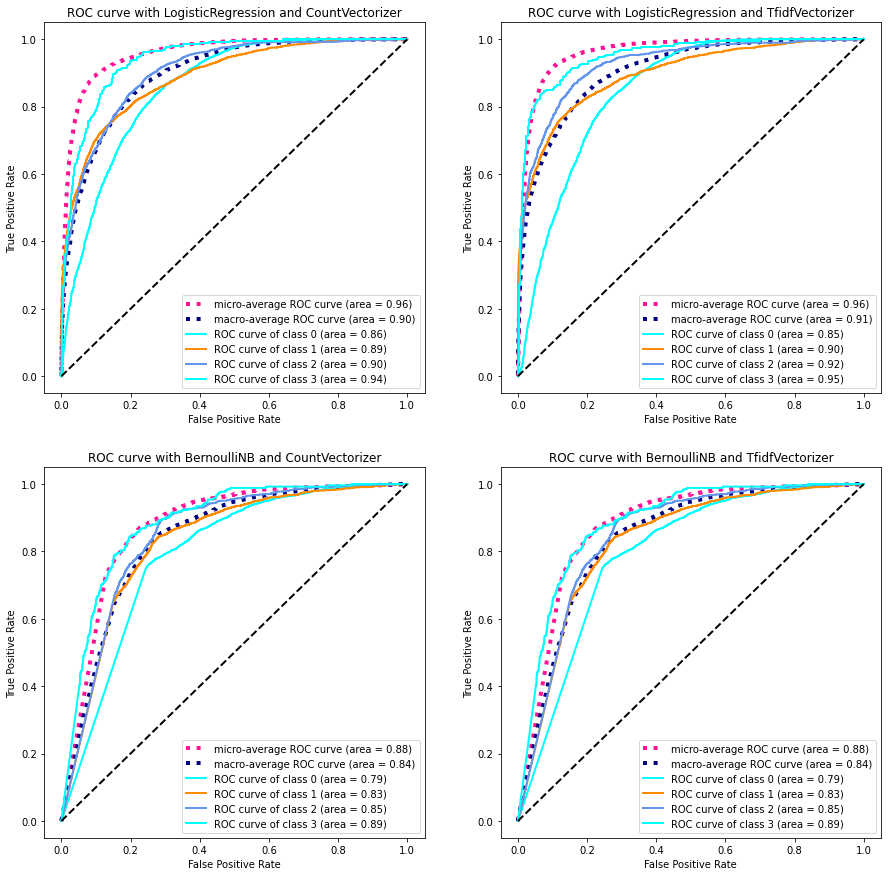

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.multiclass import OneVsRestClassifier

from sklearn.metrics import plot_roc_curve, roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

lr = LogisticRegression(multi_class="multinomial")
bn = BernoulliNB()

model_names = ["LogisticRegression", "BernoulliNB"]
enc_names = ["CountVectorizer", "TfidfVectorizer"]

model_dict = {}

fig, axs = plt.subplots(2, 2, figsize=(15,15))
for model_id, model in enumerate([lr, bn]):
    for enc_id, enc in enumerate([train_tfidf_encoding, train_count_encoding]):
        _x_train, _x_test, _y_train, _y_test = train_test_split(enc, train_binarized_y, test_size=0.3, random_state=42)

        classifier = OneVsRestClassifier(model)
        y_score = classifier.fit(_x_train, _y_train).predict_proba(_x_test)

        model_dict[f"{model_names[model_id]}_with_{enc_names[enc_id]}"] = classifier

        title = f"ROC curve with {model_names[model_id]} and {enc_names[enc_id]}"
        roc_processor(_y_test, y_score, axs[model_id, enc_id], title)

### Output predictions

In [ ]:
model_dict

{'BernoulliNB_with_CountVectorizer': OneVsRestClassifier(estimator=BernoulliNB()),
 'BernoulliNB_with_TfidfVectorizer': OneVsRestClassifier(estimator=BernoulliNB()),
 'LogisticRegression_with_CountVectorizer': OneVsRestClassifier(estimator=LogisticRegression(multi_class='multinomial')),
 'LogisticRegression_with_TfidfVectorizer': OneVsRestClassifier(estimator=LogisticRegression(multi_class='multinomial'))}

In [ ]:
def convert_predict(_multi_model, _x_test):
    _multi_label = _multi_model.predict(_x_test)
    _y_pred = np.argmax(_multi_label, axis=1)
    _y_pred = list(map(lambda x: convert_int_to_stance(x), _y_pred))
    return _y_pred


In [ ]:
for model_id, model in enumerate([lr, bn]):
    for enc_id, enc in enumerate([test_tfidf_encoding, test_count_encoding]):
        
        if enc_id == 0:
            input_enc = test_tfidf_encoding
        else:
            input_enc = test_count_encoding

        pred_result = convert_predict(model_dict[f"{model_names[model_id]}_with_{enc_names[enc_id]}"], input_enc)
        pred_stances_df = test_stances_df.copy(deep=True)[["Headline", "Body ID","Stance"]]
        pred_stances_df["Stance"] = pred_result
        pred_stances_df.to_csv(f"{model_names[model_id]}_with_{enc_names[enc_id]}"+".csv", index=False)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix

for model_id, model in enumerate([lr, bn]):
    for enc_id, enc in enumerate([test_tfidf_encoding, test_count_encoding]):
        _multi_model = model_dict[f"{model_names[model_id]}_with_{enc_names[enc_id]}"]
        
        if enc_id == 0:
            input_enc = test_tfidf_encoding
        else:
            input_enc = test_count_encoding
        
        _multi_label = _multi_model.predict(input_enc)
        _y_pred = np.argmax(_multi_label, axis=1)
        
        y_trues_for_output, y_preds_for_output = test_df["Stance"], _y_pred

        acc = accuracy_score(y_trues_for_output, y_preds_for_output)
        pre = precision_score(y_trues_for_output, y_preds_for_output, average="weighted")
        f1 = f1_score(y_trues_for_output, y_preds_for_output, average="weighted")
        print(f"{model_names[model_id]}_with_{enc_names[enc_id]}:")
        print(f"accuracy_score={acc}, precision_score={pre}, f1_score={f1}.\n")
        confusion_matrix(y_trues_for_output, y_preds_for_output)


LogisticRegression_with_CountVectorizer:
accuracy_score=0.706331405186322, precision_score=0.5818636367482759, f1_score=0.6216797295066462.

LogisticRegression_with_TfidfVectorizer:
accuracy_score=0.5767127060953056, precision_score=0.573692708912202, f1_score=0.5727592958512385.

BernoulliNB_with_CountVectorizer:
accuracy_score=0.6654468185574313, precision_score=0.5656983124988954, f1_score=0.6089340225893998.

BernoulliNB_with_TfidfVectorizer:
accuracy_score=0.6654468185574313, precision_score=0.5656983124988954, f1_score=0.6089340225893998.



In [ ]:
! python fnc-1/scorer.py fnc-1/competition_test_stances.csv BernoulliNB_with_CountVectorizer.csv

CONFUSION MATRIX:
-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |     0     |     0     |    140    |   1763    |
-------------------------------------------------------------
| disagree  |     0     |     0     |    20     |    677    |
-------------------------------------------------------------
|  discuss  |     0     |     0     |    756    |   3708    |
-------------------------------------------------------------
| unrelated |     0     |     0     |   2194    |   16155   |
-------------------------------------------------------------
ACCURACY: 0.665

MAX  - the best possible score (100% accuracy)
NULL - score as if all predicted stances were unrelated
TEST - score based on the provided predictions

||    MAX    ||    NULL   ||    TEST   ||
|| 11651.25  ||  4587.25  ||  4834.75  ||



In [ ]:
! python fnc-1/scorer.py fnc-1/competition_test_stances.csv BernoulliNB_with_TfidfVectorizer.csv

CONFUSION MATRIX:
-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |     0     |     0     |    140    |   1763    |
-------------------------------------------------------------
| disagree  |     0     |     0     |    20     |    677    |
-------------------------------------------------------------
|  discuss  |     0     |     0     |    756    |   3708    |
-------------------------------------------------------------
| unrelated |     0     |     0     |   2194    |   16155   |
-------------------------------------------------------------
ACCURACY: 0.665

MAX  - the best possible score (100% accuracy)
NULL - score as if all predicted stances were unrelated
TEST - score based on the provided predictions

||    MAX    ||    NULL   ||    TEST   ||
|| 11651.25  ||  4587.25  ||  4834.75  ||



In [ ]:
! python fnc-1/scorer.py fnc-1/competition_test_stances.csv LogisticRegression_with_CountVectorizer.csv

CONFUSION MATRIX:
-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |     0     |     0     |    50     |   1853    |
-------------------------------------------------------------
| disagree  |     0     |     0     |     2     |    695    |
-------------------------------------------------------------
|  discuss  |     0     |     0     |    420    |   4044    |
-------------------------------------------------------------
| unrelated |     0     |     0     |    819    |   17530   |
-------------------------------------------------------------
ACCURACY: 0.706

MAX  - the best possible score (100% accuracy)
NULL - score as if all predicted stances were unrelated
TEST - score based on the provided predictions

||    MAX    ||    NULL   ||    TEST   ||
|| 11651.25  ||  4587.25  ||  4815.5   ||



In [ ]:
! python fnc-1/scorer.py fnc-1/competition_test_stances.csv LogisticRegression_with_TfidfVectorizer.csv

CONFUSION MATRIX:
-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |    150    |     0     |    166    |   1587    |
-------------------------------------------------------------
| disagree  |    27     |     0     |    86     |    584    |
-------------------------------------------------------------
|  discuss  |    51     |     0     |   1557    |   2856    |
-------------------------------------------------------------
| unrelated |    806    |     0     |   4594    |   12949   |
-------------------------------------------------------------
ACCURACY: 0.577

MAX  - the best possible score (100% accuracy)
NULL - score as if all predicted stances were unrelated
TEST - score based on the provided predictions

||    MAX    ||    NULL   ||    TEST   ||
|| 11651.25  ||  4587.25  ||  5026.75  ||



## Bert Model

### Prepare TPU environment

In [ ]:
# TPU, GPU, or CPU
import os
assert os.environ['COLAB_TPU_ADDR'], 'Make sure to select TPU from Edit > Notebook settings > Hardware accelerator'

In [ ]:
!pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl


  Using cached https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl (149.9 MB)


In [ ]:
! pip install torch==1.9.0+cu111 -f https://download.pytorch.org/whl/cu111/torch_stable.html

Looking in links: https://download.pytorch.org/whl/cu111/torch_stable.html


In [ ]:
import torch
import torch_xla
import torch_xla.core.xla_model as xm
device = xm.xla_device()

In [ ]:
device

device(type='xla', index=1)

### Prepare CPU or GPU environment

In [ ]:
#device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
#device

### Prepare BERT model from network or local disk

In [ ]:
!pip install transformers

In [ ]:
from transformers.file_utils import is_torch_available, is_torch_tpu_available
from transformers import BertTokenizerFast, BertForSequenceClassification, BertForTokenClassification
from transformers import Trainer, TrainingArguments

In [ ]:
import os
local_dir = "/content/drive/MyDrive/Colab Notebooks/fnc-bert-base-uncased-epoch-3-batch-16"
os.listdir(local_dir)

['special_tokens_map.json',
 'tokenizer_config.json',
 'vocab.txt',
 'config.json',
 'pytorch_model.bin',
 'tokenizer.json']

In [ ]:
max_length = 512
tokenizer = BertTokenizerFast.from_pretrained(local_dir, local_files_only=True, do_lower_case=True)
model = BertForSequenceClassification.from_pretrained(local_dir, local_files_only=True, num_labels=4).to(device)

In [ ]:
# Prepare the pre-trained model that is needed for this project. 
# model_name = "bert-base-uncased"
# max_length = 512
# tokenizer = BertTokenizerFast.from_pretrained(model_name, do_lower_case=True)
# model = BertForSequenceClassification.from_pretrained(model_name, num_labels=4).to(dev)

### Prepare DataSet

In [ ]:
class FakeNewsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
from sklearn.model_selection import train_test_split

train_texts, valid_texts, train_labels, valid_labels = train_test_split(train_df["Mixed"].to_list(), 
                                                                        train_df["Stance"].to_list(), 
                                                                        test_size=0.2)
test_texts = test_df["Mixed"].to_list()
test_labels = test_df["Stance"].to_list()

In [ ]:
# tokenize the dataset, truncate when passed `max_length`, 
# and pad with 0's when less than `max_length`
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=max_length)
valid_encodings = tokenizer(valid_texts, truncation=True, padding=True, max_length=max_length)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=max_length)

In [ ]:
train_dataset = FakeNewsDataset(train_encodings, train_labels)
valid_dataset = FakeNewsDataset(valid_encodings, valid_labels)
test_dataset = FakeNewsDataset(test_encodings, test_labels)

### Train BERT model

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  # calculate accuracy using sklearn's function
  acc = accuracy_score(labels, preds)
  return {
      'accuracy': acc,
  }

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    load_best_model_at_end=True,     # load the best model when finished training (default metric is loss)
    # but you can specify `metric_for_best_model` argument to change to accuracy or other metric
    logging_steps=100,               # log & save weights each logging_steps
    save_steps=1000,
    evaluation_strategy="steps",     # evaluate each `logging_steps`
)

In [ ]:
trainer = Trainer(
    model=model,                         # the instantiated Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=valid_dataset,          # evaluation dataset
    compute_metrics=compute_metrics,     # the callback that computes metrics of interest
)

In [ ]:
#trainer.train()

In [ ]:
"""
from distutils.dir_util import copy_tree

driver_dir = "/content/drive/MyDrive/Colab Notebooks"
model_path = "fnc-"+model_name+"-epoch-3-batch-16"

model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

copy_tree(model_path, os.path.join(driver_dir, model_path))
"""

'\nfrom distutils.dir_util import copy_tree\n\ndriver_dir = "/content/drive/MyDrive/Colab Notebooks"\nmodel_path = "fnc-"+model_name+"-epoch-3-batch-16"\n\nmodel.save_pretrained(model_path)\ntokenizer.save_pretrained(model_path)\n\ncopy_tree(model_path, os.path.join(driver_dir, model_path))\n'

In [ ]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 9995
  Batch size = 64


{'eval_accuracy': 0.9919959979989995,
 'eval_loss': 0.03280932456254959,
 'eval_runtime': 194.7622,
 'eval_samples_per_second': 51.319,
 'eval_steps_per_second': 0.806}

### Test

In [ ]:
from torch.utils.data import DataLoader
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)
test_dataloader

In [ ]:
from sklearn.preprocessing import label_binarize

y_trues_for_test = np.array(label_binarize(test_labels, classes=[0, 1, 2, 3]))
y_preds_for_test = []

model.eval()
for batch in test_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    y_pred= torch.softmax(outputs.logits, dim=1).tolist()
    y_preds_for_test.extend(y_pred)

y_preds_for_test = np.array(y_preds_for_test)


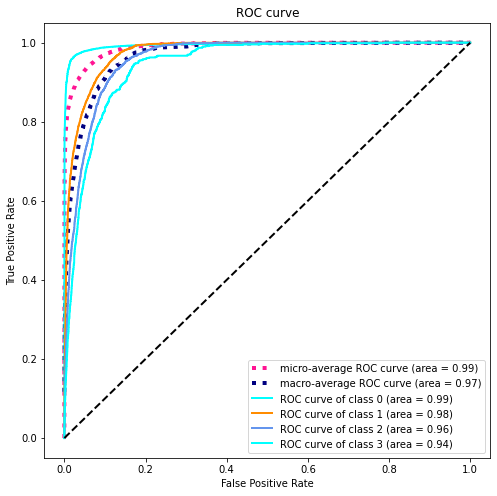

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

fig, axs = plt.subplots(1, 1, figsize=(8,8))

title = f"ROC curve"
roc_processor(y_trues_for_test, y_preds_for_test, axs, title)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix
y_preds_for_output = np.argmax(y_preds_for_test, axis=1)
y_trues_for_output = np.argmax(y_trues_for_test, axis=1)

acc = accuracy_score(y_trues_for_output, y_preds_for_output)
pre = precision_score(y_trues_for_output, y_preds_for_output, average="weighted")
f1 = f1_score(y_trues_for_output, y_preds_for_output, average="weighted")

print(f"accuracy_score={acc}, precision_score={pre}, f1_score={f1}.")
confusion_matrix(y_trues_for_output, y_preds_for_output)

accuracy_score=0.9037500491874237, precision_score=0.9060421347068395, f1_score=0.9043580503991685.


array([[17750,   419,   107,    73],
       [   86,  3788,   485,   105],
       [   52,   494,  1200,   157],
       [   54,   193,   221,   229]])

In [ ]:
y_preds_for_output = list(map(lambda x: convert_int_to_stance(x), y_preds_for_output))

pred_stances_df = test_stances_df.copy(deep=True)[["Headline", "Body ID","Stance"]]
pred_stances_df["Stance"] = y_preds_for_output
pred_stances_df.to_csv("BERT"+".csv", index=False)
pred_stances_df

,Headline,Body ID,Stance
0,Ferguson riots: Pregnant woman loses eye after...,2008,unrelated
1,Crazy Conservatives Are Sure a Gitmo Detainee ...,1550,unrelated
2,A Russian Guy Says His Justin Bieber Ringtone ...,2,unrelated
3,"Zombie Cat: Buried Kitty Believed Dead, Meows ...",1793,unrelated
4,Argentina's President Adopts Boy to End Werewo...,37,unrelated
...,...,...,...
25408,The success of the Affordable Care Act is a hu...,2582,agree
25409,The success of the Affordable Care Act is a hu...,2583,agree
25410,The success of the Affordable Care Act is a hu...,2584,disagree
25411,The success of the Affordable Care Act is a hu...,2585,discuss


In [ ]:
! python fnc-1/scorer.py fnc-1/competition_test_stances.csv BERT.csv

CONFUSION MATRIX:
-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |   1200    |    157    |    494    |    52     |
-------------------------------------------------------------
| disagree  |    221    |    229    |    193    |    54     |
-------------------------------------------------------------
|  discuss  |    485    |    105    |   3788    |    86     |
-------------------------------------------------------------
| unrelated |    107    |    73     |    419    |   17750   |
-------------------------------------------------------------
ACCURACY: 0.904

MAX  - the best possible score (100% accuracy)
NULL - score as if all predicted stances were unrelated
TEST - score based on the provided predictions

||    MAX    ||    NULL   ||    TEST   ||
|| 11651.25  ||  4587.25  || 10068.25  ||

